In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split


In [45]:
# Load the dataset and preview the first few rows
file_path = "/content/Bank Customer Churn Prediction.csv"
data = pd.read_csv(file_path)
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [46]:
data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [47]:
# Define features for transformation
categorical_features = ['gender', 'country']
numerical_features = [
    'credit_score', 'age', 'balance', 'products_number', 'estimated_salary'
]


In [48]:
# Define transformations for preprocessing
numerical_transformer = StandardScaler()  # Standardize numerical features
categorical_transformer = OneHotEncoder(drop='first')  # Encode categorical features


In [49]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
    ]
)

In [50]:
# Compute class weights to handle imbalanced classes in the churn column
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Classes: Not Churned (0), Churned (1)
    y=data['churn']
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [51]:
# Split the dataset into training and testing sets
X = data.drop(columns=['customer_id', 'churn'])  # Features
y = data['churn']  # Target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [52]:
# Create and train a logistic regression pipeline
logreg_pipeline = make_pipeline(
    preprocessor,  # Apply preprocessing
    LogisticRegression(class_weight=class_weights_dict, random_state=42)  # Classifier
)
logreg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['credit_score', 'age',
                                                   'balance', 'products_number',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['gender', 'country'])])),
                ('logisticregression',
                 LogisticRegression(class_weight={0: 0.6279040562602034,
                                                  1: 2.454590083456063},
                                    random_state=42))])

In [53]:
# Evaluate the model
y_pred = logreg_pipeline.predict(X_test)  # Generate predictions
y_pred_proba = logreg_pipeline.predict_proba(X_test)[:, 1]  # Probability estimates
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.71      0.79      1593
           1       0.38      0.69      0.49       407

    accuracy                           0.70      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.79      0.70      0.73      2000



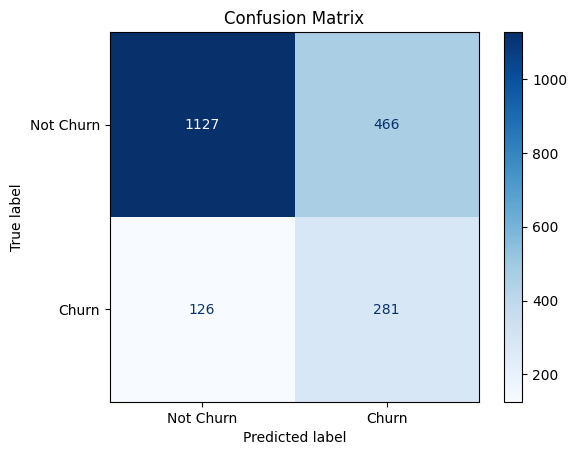

In [54]:
# Visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Not Churn", "Churn"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()


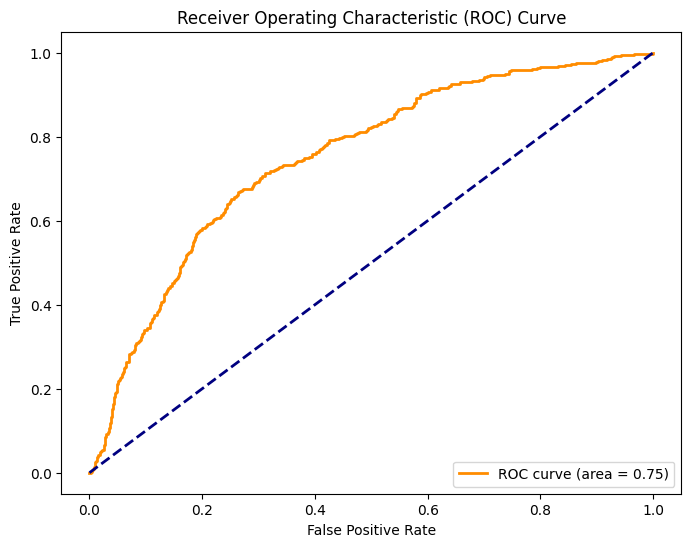

In [55]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

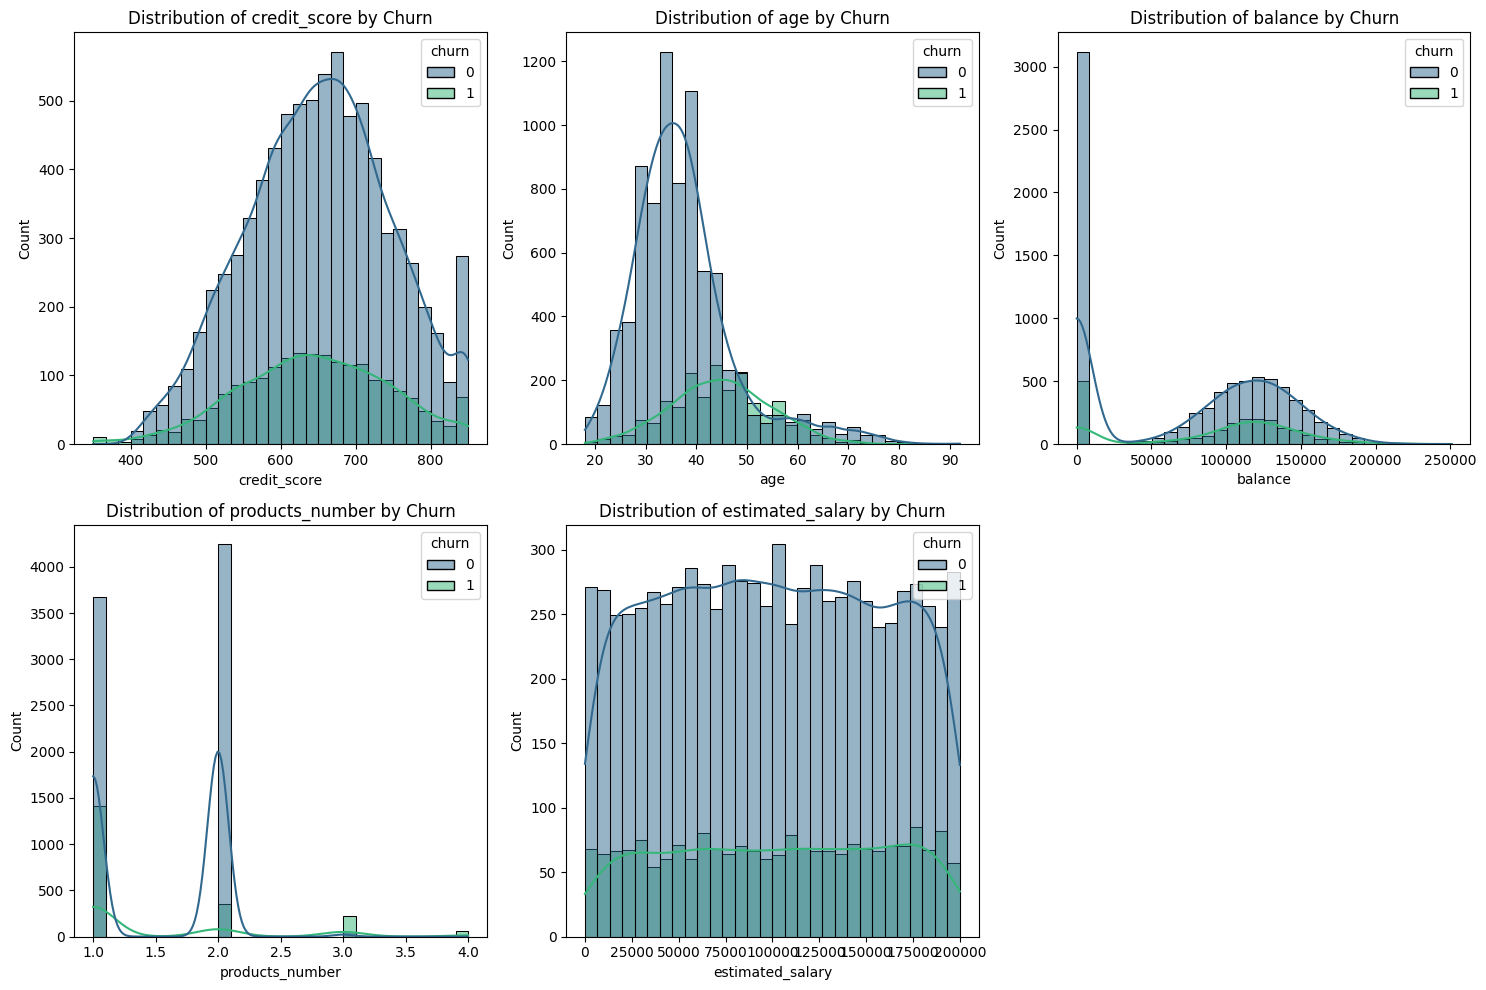

In [56]:

# Visualize feature distributions by churn status
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data, x=feature, hue='churn', kde=True, palette='viridis', bins=30)
    plt.title(f"Distribution of {feature} by Churn")
plt.tight_layout()
plt.show()


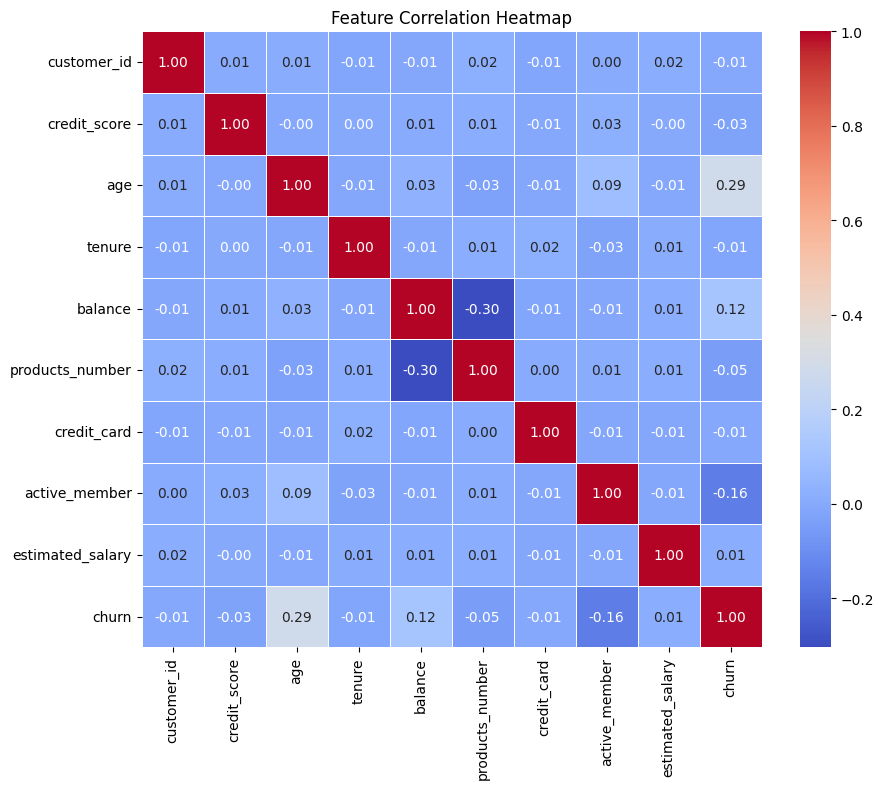

In [57]:

# Plot a correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
correlation = data.corr(numeric_only=True)
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()